# Understanding and predicting data with linear regression models

This is the code is adapted from [Bayesian Analysis with Python](https://github.com/aloctavodia/BAP).


In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
palette = 'muted'
sns.set_palette(palette); sns.set_color_codes(palette)
np.set_printoptions(precision=2)
pd.set_option('display.precision', 2)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/home/ohalloranb/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## The gamma distribution

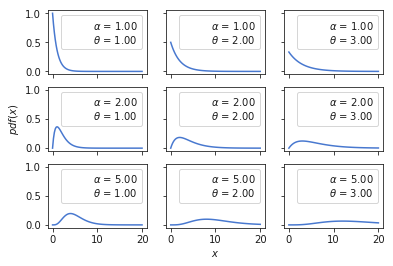

In [2]:
rates = [1, 2, 5]
scales = [1, 2, 3]

x = np.linspace(0, 20, 100)
f, ax = plt.subplots(len(rates), len(scales), sharex=True, sharey=True)
for i in range(len(rates)):
    for j in range(len(scales)):
        rate = rates[i]
        scale = scales[j]
        rv = stats.gamma(a=rate, scale=scale)
        ax[i,j].plot(x, rv.pdf(x))
        ax[i,j].plot(0, 0, 
        label="$\\alpha$ = {:3.2f}\n$\\theta$ = {:3.2f}".format(rate, scale), alpha=0)
        ax[i,j].legend()
ax[2,1].set_xlabel('$x$')
ax[1,0].set_ylabel('$pdf(x)$')


## Simple linear regression

In [3]:
np.random.seed(1)
N = 100
alfa_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)

x = np.random.normal(10, 1, N)
y_real = alfa_real + beta_real * x 
y = y_real + eps_real

# we can center the data
#x = x - x.mean()
# or standardize the data
#x = (x - x.mean())/x.std()
#y = (y - y.mean())/y.std()

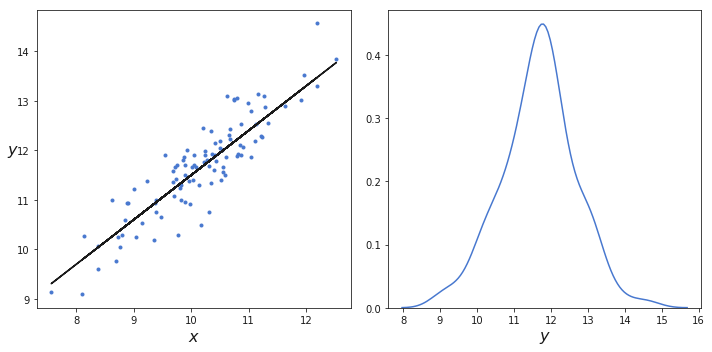

In [4]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(x, y, 'b.')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.plot(x, y_real, 'k')
plt.subplot(1,2,2)
sns.kdeplot(y)
plt.xlabel('$y$', fontsize=16)
plt.tight_layout()


In [5]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = pm.Deterministic('mu', alpha + beta * x)
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    
    start = pm.find_MAP() 
    step = pm.Metropolis() 
    trace = pm.sample(10000, step, start)

logp = -66.676, ||grad|| = 48.412: 100%|██████████| 38/38 [00:00<00:00, 3168.28it/s]         
100%|██████████| 10500/10500 [00:02<00:00, 4094.21it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdecc165898>,
      dtype=object)

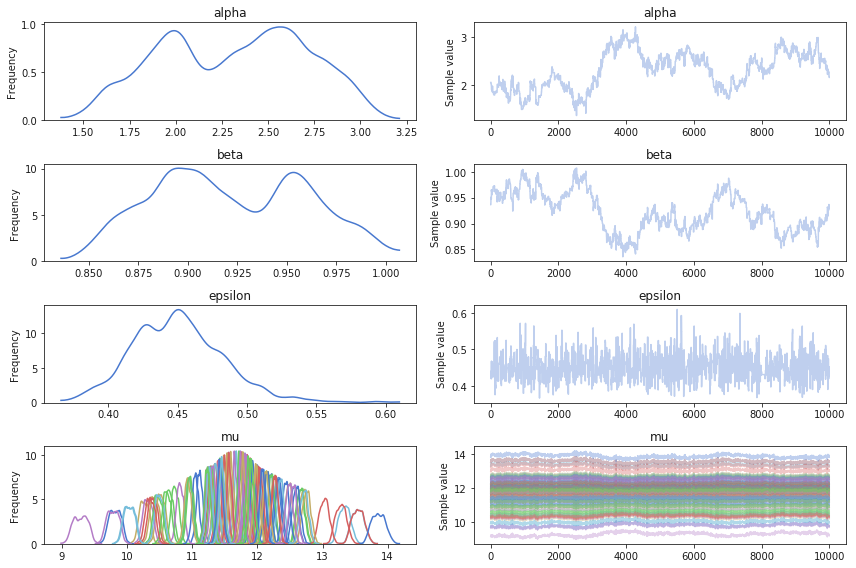

In [6]:
pm.traceplot(trace)


In [7]:
#pm.df_summary(trace)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fded16bd518>],
      dtype=object)

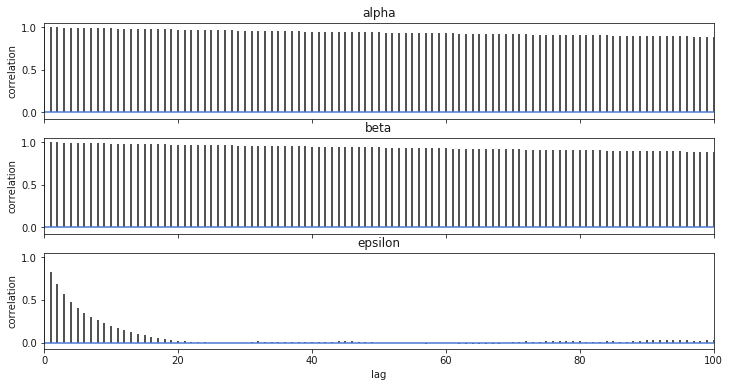

In [8]:
varnames = ['alpha', 'beta', 'epsilon']
pm.autocorrplot(trace, varnames)


### Modyfing the data before running the models

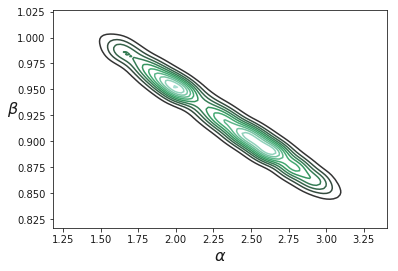

In [9]:
sns.kdeplot(trace['alpha'], trace['beta'])
plt.xlabel(r'$\alpha$', fontsize=16)
plt.ylabel(r'$\beta$', fontsize=16, rotation=0)


### Changing the sampling method

In [10]:
with pm.Model() as model_n:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    
    mu = pm.Deterministic('mu', alpha + beta * x)

    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    
    start = pm.find_MAP() 
    step = pm.NUTS() 
    trace_n = pm.sample(2000, step=step, start=start)

logp = -66.676, ||grad|| = 48.412: 100%|██████████| 38/38 [00:00<00:00, 3524.78it/s]         
/home/ohalloranb/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|██████████| 2500/2500 [00:08<00:00, 293.25it/s]


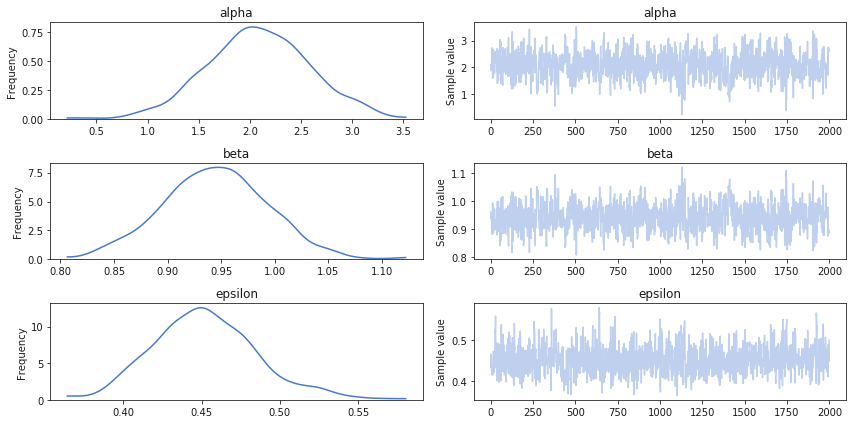

In [11]:
pm.traceplot(trace_n, varnames);

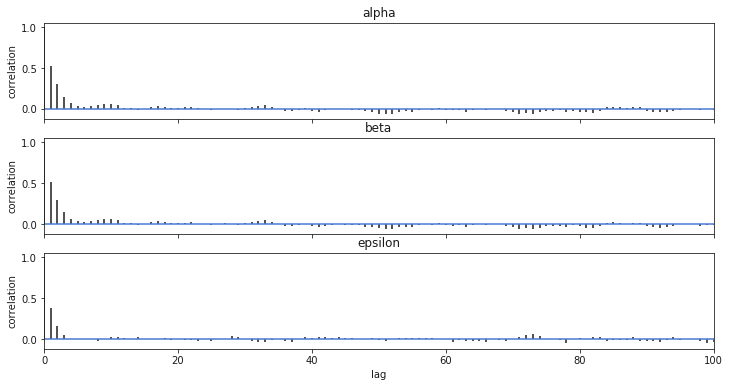

In [12]:
pm.autocorrplot(trace_n, varnames);

In [13]:
pm.df_summary(trace_n, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,2.08,0.50,2.02e-02,1.19,3.13
beta,0.94,0.05,1.96e-03,0.84,1.03
epsilon,0.45,0.03,1.05e-03,0.39,0.52


### Posterior predictive checks

In [14]:
ppc = pm.sample_ppc(trace_n, samples=231, model=model_n)

100%|██████████| 231/231 [00:00<00:00, 2584.53it/s]


/home/ohalloranb/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2400: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


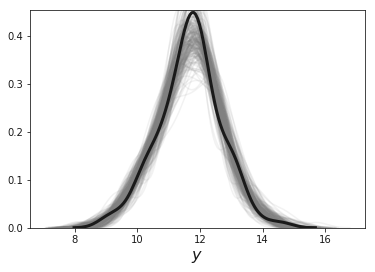

In [15]:
# predicted data
for y_tilde in ppc['y_pred']:
    sns.kdeplot(y_tilde, alpha=0.1, c='gray')
# actual data
sns.kdeplot(y, linewidth=3, color='k')
plt.xlabel('$y$', fontsize=16);

### interpreting the posterior

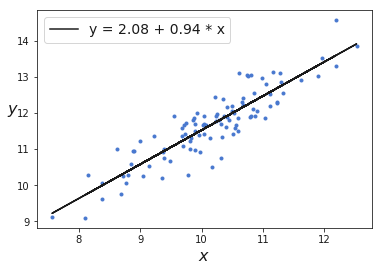

In [16]:
plt.plot(x, y, 'b.');
alpha_m = trace_n['alpha'].mean()
beta_m = trace_n['beta'].mean()
plt.plot(x, alpha_m + beta_m * x, c='k', label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.legend(loc=2, fontsize=14)


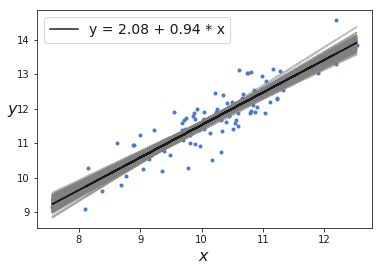

In [17]:
plt.plot(x, y, 'b.');

idx = range(0, len(trace_n['alpha']), 10)
plt.plot(x, trace_n['alpha'][idx] + trace_n['beta'][idx] *  x[:,np.newaxis], c='gray', alpha=0.5);

plt.plot(x, alpha_m + beta_m * x, c='k', label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.legend(loc=2, fontsize=14)


Text(0,0.5,'$y$')

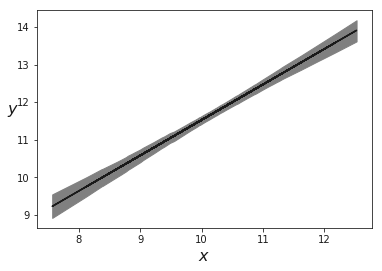

In [18]:
plt.plot(x, alpha_m + beta_m * x, c='k', label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))

idx = np.argsort(x)
x_ord = x[idx]
sig = pm.hpd(trace_n['mu'], alpha=.02)[idx]
plt.fill_between(x_ord, sig[:,0], sig[:,1], color='gray')

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)


In [19]:
ppc = pm.sample_ppc(trace_n, samples=1000, model=model_n)

100%|██████████| 1000/1000 [00:00<00:00, 3981.24it/s]


Text(0,0.5,'$y$')

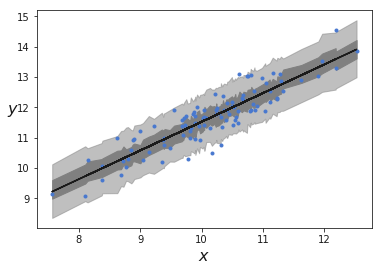

In [20]:
plt.plot(x, y, 'b.')
plt.plot(x, alpha_m + beta_m * x, c='k', label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))

sig0 = pm.hpd(ppc['y_pred'], alpha=0.5)[idx]
sig1 = pm.hpd(ppc['y_pred'], alpha=0.05)[idx]
plt.fill_between(x_ord, sig0[:,0], sig0[:,1], color='gray', alpha=1)
plt.fill_between(x_ord, sig1[:,0], sig1[:,1], color='gray', alpha=0.5)

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)


## Pearson correlation coefficient

In [21]:
with pm.Model() as model_n:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    
    mu = alpha + beta * x
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)

    rb = pm.Deterministic('rb', (beta * x.std() / y.std()) ** 2)

    y_mean = y.mean()
    ss_reg = pm.math.sum((mu - y_mean) ** 2)
    ss_tot = pm.math.sum((y - y_mean) ** 2)
    rss = pm.Deterministic('rss', ss_reg/ss_tot)

    start = pm.find_MAP()
    step = pm.NUTS()
    trace_n = pm.sample(2000, step=step, start=start)

logp = -66.676, ||grad|| = 48.412: 100%|██████████| 38/38 [00:00<00:00, 2823.20it/s]         
/home/ohalloranb/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|██████████| 2500/2500 [00:08<00:00, 300.47it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdf14522668>,
      dtype=object)

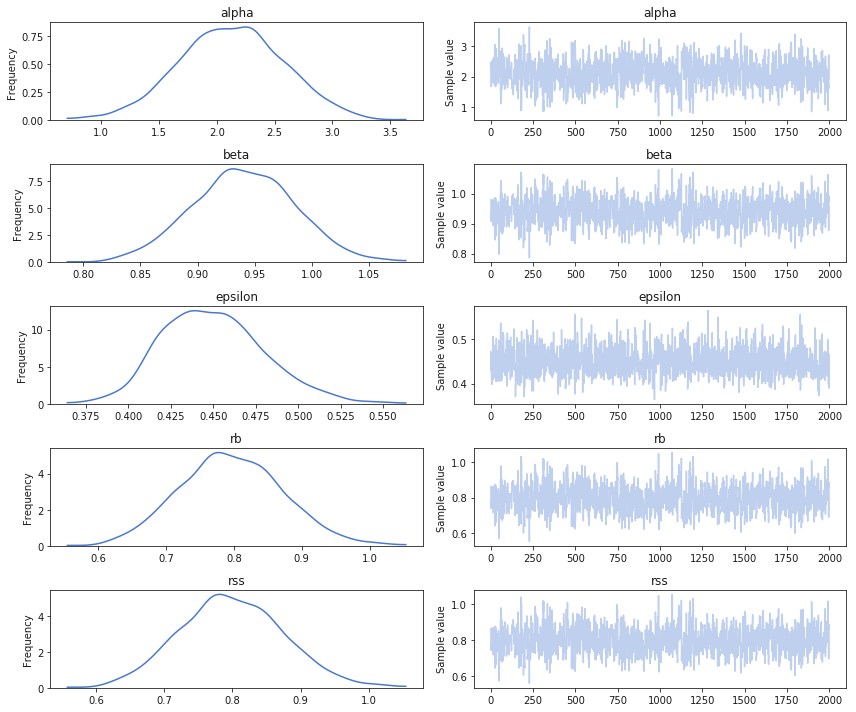

In [22]:
pm.traceplot(trace_n)


In [23]:
pm.df_summary(trace_n)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,2.12,0.45,1.59e-02,1.24,3.02
beta,0.94,0.04,1.55e-03,0.86,1.03
epsilon,0.45,0.03,8.04e-04,0.40,0.51
rb,0.80,0.08,2.61e-03,0.65,0.94
rss,0.80,0.08,2.62e-03,0.66,0.96


### The multivariate normal distribution 
Actualy the bivariate

Text(0,0.5,'$x_2$')

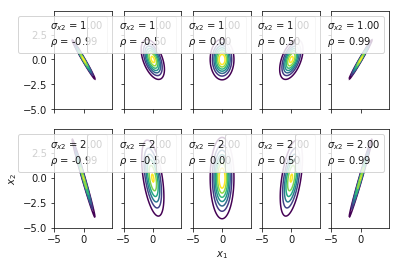

In [24]:
sigma_x1 = 1
sigmas_x2 = [1, 2]
rhos = [-0.99, -0.5, 0, 0.5, 0.99]

k, l = np.mgrid[-5:5:.1, -5:5:.1]
pos = np.empty(k.shape + (2,))
pos[:, :, 0] = k; pos[:, :, 1] = l

f, ax = plt.subplots(len(sigmas_x2), len(rhos), sharex=True, sharey=True)
#f.figure(figsize=(5, 1))
for i in range(2):
    for j in range(5):
        sigma_x2 = sigmas_x2[i]
        rho = rhos[j]
        cov = [[sigma_x1**2, sigma_x1*sigma_x2*rho], [sigma_x1*sigma_x2*rho, sigma_x2**2]]
        rv = stats.multivariate_normal([0, 0], cov)
        ax[i,j].contour(k, l, rv.pdf(pos))
        ax[i,j].plot(0, 0, 
        label="$\\sigma_{{x2}}$ = {:3.2f}\n$\\rho$ = {:3.2f}".format(sigma_x2, rho), alpha=0)
        ax[i,j].legend()
ax[1,2].set_xlabel('$x_1$')
ax[1,0].set_ylabel('$x_2$')


In [25]:
data = np.stack((x, y)).T

In [26]:
with pm.Model() as pearson_model:
    
    mu = pm.Normal('mu', mu=data.mean(0), sd=10, shape=2)
    
    sigma_1 = pm.HalfNormal('simga_1', 10)
    sigma_2 = pm.HalfNormal('sigma_2', 10)
    rho = pm.Uniform('rho', -1, 1)
    
    cov = pm.math.stack(([sigma_1**2, sigma_1*sigma_2*rho], [sigma_1*sigma_2*rho, sigma_2**2]))
    
    y_pred = pm.MvNormal('y_pred', mu=mu, cov=cov, observed=data)
    
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_p = pm.sample(1000, step=step, start=start)

logp = -210.34, ||grad|| = 17.552: 100%|██████████| 17/17 [00:00<00:00, 1146.72it/s] 
/home/ohalloranb/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|██████████| 1500/1500 [00:08<00:00, 184.60it/s]


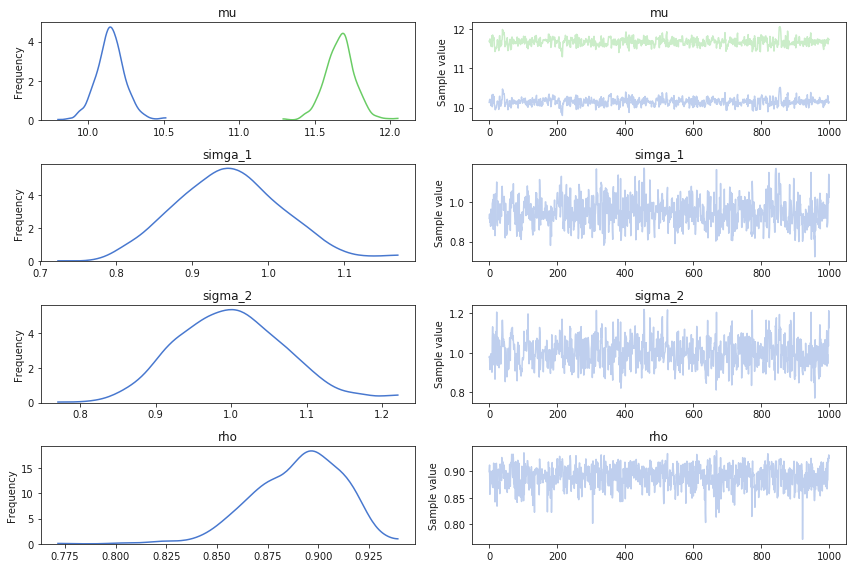

In [27]:
pm.traceplot(trace_p);


In [28]:
pm.df_summary(trace_p)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
mu__0,10.15,0.09,4.51e-03,9.95,10.32
mu__1,11.67,0.10,4.69e-03,11.48,11.85
simga_1,0.95,0.07,3.07e-03,0.80,1.07
sigma_2,1.00,0.07,3.17e-03,0.86,1.14
rho,0.89,0.02,8.63e-04,0.85,0.93


## Robust linear regression

In [29]:
ans = sns.load_dataset('anscombe')
x_3 = ans[ans.dataset == 'III']['x'].values
y_3 = ans[ans.dataset == 'III']['y'].values

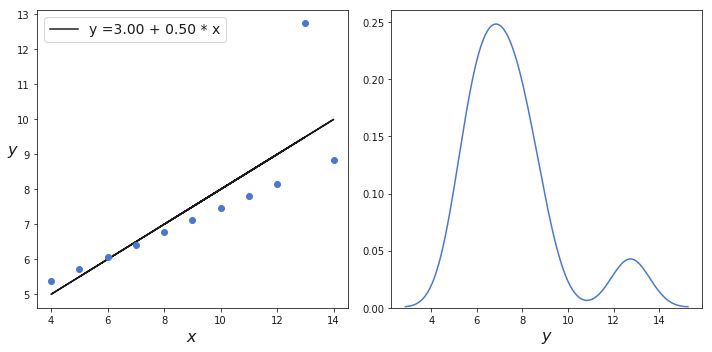

In [30]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]
plt.plot(x_3, (alpha_c + beta_c* x_3), 'k', label='y ={:.2f} + {:.2f} * x'.format(alpha_c, beta_c))
plt.plot(x_3, y_3, 'bo')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', rotation=0, fontsize=16)
plt.legend(loc=0, fontsize=14)
plt.subplot(1,2,2)
sns.kdeplot(y_3);
plt.xlabel('$y$', fontsize=16)
plt.tight_layout()


In [31]:
with pm.Model() as model_t:
    alpha = pm.Normal('alpha', mu=0, sd=100)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    nu = pm.Deterministic('nu', pm.Exponential('nu_', 1/29) + 1)
    
    y_pred = pm.StudentT('y_pred', mu=alpha + beta * x_3, sd=epsilon, nu=nu, observed=y_3)

    start = pm.find_MAP()
    step = pm.NUTS(scaling=start) 
    trace_t = pm.sample(2000, step=step, start=start)

logp = -59.838, ||grad|| = 17,045: 100%|██████████| 144/144 [00:00<00:00, 3081.07it/s]    
/home/ohalloranb/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|██████████| 2500/2500 [02:28<00:00, 16.85it/s]/home/ohalloranb/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:459: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)
/home/ohalloranb/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 50 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))



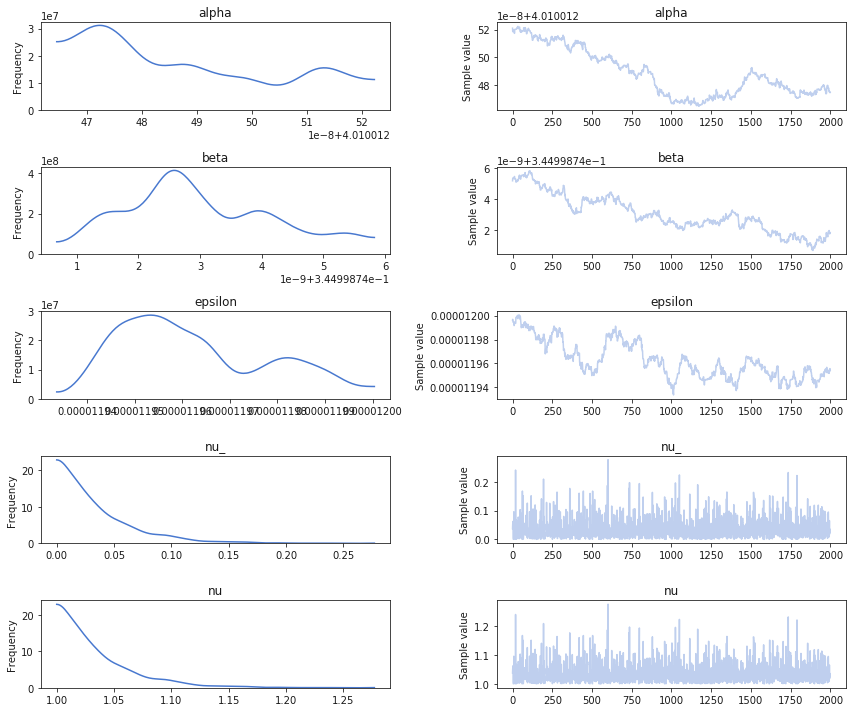

In [32]:
pm.traceplot(trace_t);

In [33]:
pm.df_summary(trace_t)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,4.01e+00,1.69e-08,1.69e-09,4.01e+00,4.01e+00
beta,3.45e-01,1.19e-09,1.19e-10,3.45e-01,3.45e-01
epsilon,1.20e-05,1.55e-08,1.53e-09,1.19e-05,1.20e-05
nu_,3.55e-02,3.53e-02,8.19e-04,3.04e-05,1.05e-01
nu,1.04e+00,3.53e-02,8.19e-04,1.00e+00,1.11e+00


In [34]:
#pm.autocorrplot(cadena_t, varnames);

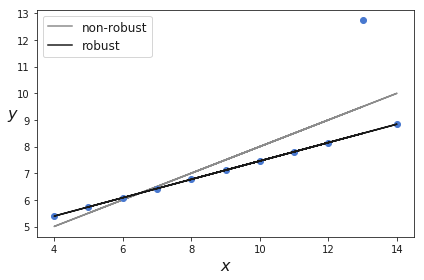

In [35]:
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]

plt.plot(x_3, (alpha_c + beta_c * x_3), 'k', label='non-robust', alpha=0.5)
plt.plot(x_3, y_3, 'bo')
alpha_m = trace_t['alpha'].mean()
beta_m = trace_t['beta'].mean()
plt.plot(x_3, alpha_m + beta_m * x_3, c='k', label='robust')

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', rotation=0, fontsize=16)
plt.legend(loc=2, fontsize=12)
plt.tight_layout()



In [36]:
ppc = pm.sample_ppc(trace_t, samples=200, model=model_t, random_seed=2)

100%|██████████| 200/200 [00:00<00:00, 366.42it/s]


/home/ohalloranb/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2400: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


Text(0.5,0,'$y$')

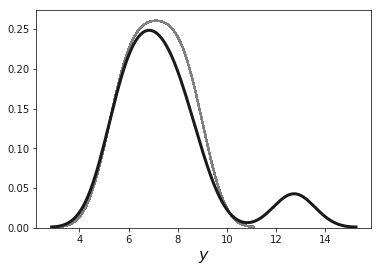

In [37]:
# predicted data
for y_tilde in ppc['y_pred']:
    sns.kdeplot(y_tilde, alpha=0.5, c='gray')

# actual data
sns.kdeplot(y_3, linewidth=3, color='k')
plt.xlabel('$y$', fontsize=16)


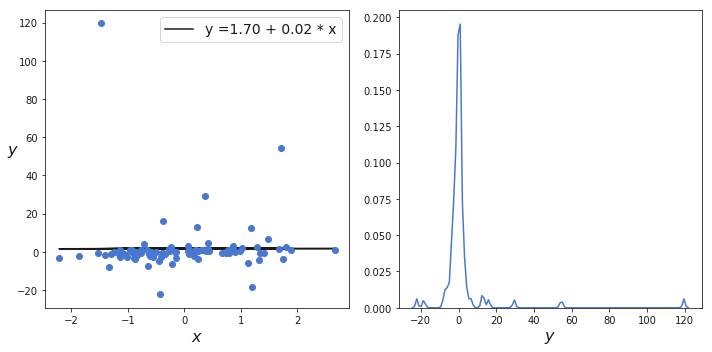

In [38]:
np.random.seed(314)
x_4 = np.random.normal(size=100)
y_4 = x_4 + np.random.standard_t(df=1, size=100) # experiments with different values of df

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
beta_c, alpha_c = stats.linregress(x_4, y_4)[:2]
plt.plot(x_4, (alpha_c + beta_c* x_4), 'k', label='y ={:.2f} + {:.2f} * x'.format(alpha_c, beta_c))
plt.plot(x_4, y_4, 'bo')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', rotation=0, fontsize=16)
plt.legend(loc=0, fontsize=14)
plt.subplot(1,2,2)
sns.kdeplot(y_4);
plt.xlabel('$y$', fontsize=16)
plt.tight_layout()

In [39]:
with pm.Model() as model_t2:
    alpha = pm.Normal('alpha', mu=0, sd=100)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    nu = pm.Exponential('nu', 1/30)
    #nu = pm.Gamma('nu', mu=20, sd=15)
    #nu = pm.Gamma('nu', 2, 0.1)

    
    y_pred = pm.StudentT('y_pred', mu=alpha + beta * x_4, sd=epsilon, nu=nu, observed=y_4)

    start = pm.find_MAP()
    step = pm.NUTS(scaling=start) 
    trace_t2 = pm.sample(2000, step=step, start=start)

logp = -272.44, ||grad|| = 0.013845: 100%|██████████| 14/14 [00:00<00:00, 1962.25it/s]  
/home/ohalloranb/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|██████████| 2500/2500 [00:01<00:00, 1310.95it/s]


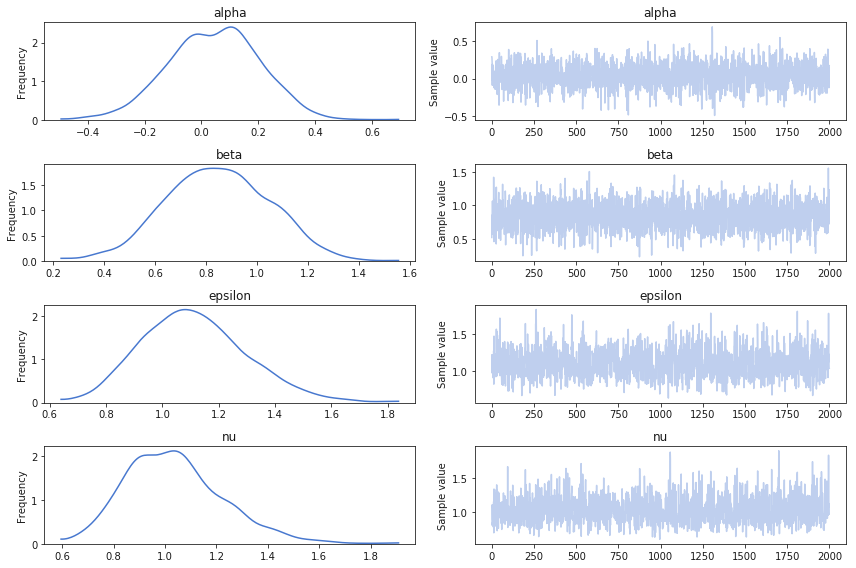

In [40]:
pm.traceplot(trace_t2);

In [41]:
pm.df_summary(trace_t2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,0.05,0.16,3.16e-03,-0.26,0.35
beta,0.84,0.20,3.28e-03,0.48,1.26
epsilon,1.11,0.19,5.08e-03,0.78,1.49
nu,1.04,0.19,5.39e-03,0.71,1.44


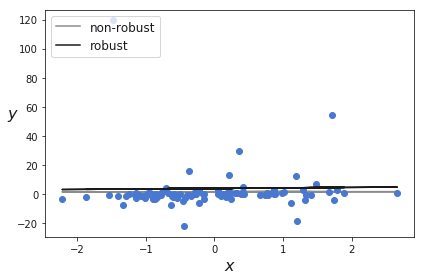

In [44]:
beta_c, alpha_c = stats.linregress(x_4, y_4)[:2]

plt.plot(x_4, (alpha_c + beta_c * x_4), 'k', label='non-robust', alpha=0.5)
plt.plot(x_4, y_4, 'bo')
alpha_m = trace_t['alpha'].mean()
beta_m = trace_t['beta'].mean()
plt.plot(x_4, alpha_m + beta_m * x_4, c='k', label='robust')

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', rotation=0, fontsize=16)
plt.legend(loc=2, fontsize=12)
plt.tight_layout()

## Hierarchical linear regression

In [45]:
N = 20
M = 8
idx = np.repeat(range(M-1), N)
idx = np.append(idx, 7)
np.random.seed(314)

alpha_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(6, 1, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))

y_m = np.zeros(len(idx))
x_m = np.random.normal(10, 1, len(idx))
y_m = alpha_real[idx] + beta_real[idx] * x_m  + eps_real

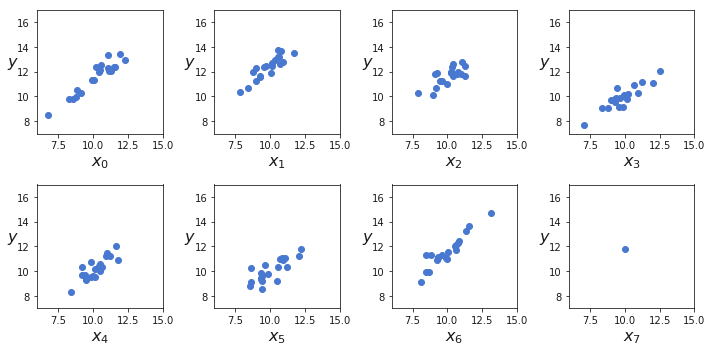

In [46]:
plt.figure(figsize=(10,5))
j, k = 0, N
for i in range(M):
    plt.subplot(2,4,i+1)
    plt.scatter(x_m[j:k], y_m[j:k])
    plt.xlabel('$x_{}$'.format(i), fontsize=16)
    plt.ylabel('$y$', fontsize=16, rotation=0)
    plt.xlim(6, 15)
    plt.ylim(7, 17)
    j += N
    k += N
plt.tight_layout()


In [47]:
x_centered = x_m - x_m.mean()

In [48]:
with pm.Model() as unpooled_model:
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sd=10, shape=M)
    beta = pm.Normal('beta', mu=0, sd=10, shape=M)
    epsilon = pm.HalfCauchy('epsilon', 5)
    nu = pm.Exponential('nu', 1/30)

    y_pred = pm.StudentT('y_pred', mu= alpha_tmp[idx] + beta[idx] * x_centered, sd=epsilon, nu=nu, observed=y_m)

    alpha = pm.Deterministic('alpha', alpha_tmp - beta * x_m.mean()) 
    
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_up = pm.sample(2000, step=step, start=start)

logp = -150.1, ||grad|| = 0.063829: 100%|██████████| 75/75 [00:00<00:00, 2817.34it/s]  
/home/ohalloranb/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|██████████| 2500/2500 [00:03<00:00, 830.82it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fde8077f080>,
      dtype=object)

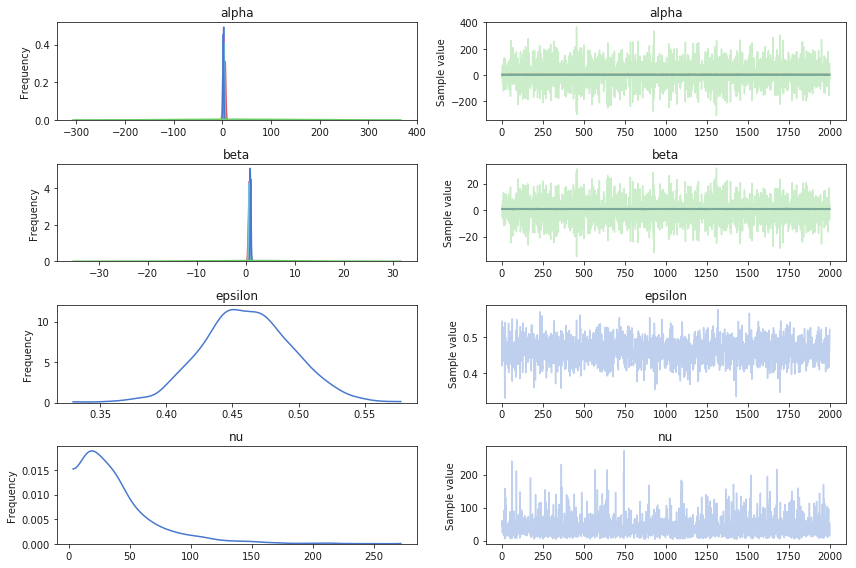

In [49]:
varnames=['alpha', 'beta', 'epsilon', 'nu']
pm.traceplot(trace_up, varnames)


In [50]:
#pm.autocorrplot(trace_up, varnames=[epsilon, nu]);

In [51]:
pm.df_summary(trace_up, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha__0,2.43,0.78,1.19e-02,0.89,3.94
alpha__1,3.72,1.16,1.58e-02,1.46,5.86
alpha__2,5.68,1.28,1.76e-02,3.06,8.16
alpha__3,3.07,0.88,1.45e-02,1.41,4.79
alpha__4,1.34,1.27,2.03e-02,-1.25,3.71
alpha__5,3.19,1.01,1.52e-02,1.27,5.27
alpha__6,1.77,0.88,1.49e-02,0.02,3.50
alpha__7,14.47,97.34,1.62e+00,-177.14,190.86
beta__0,0.89,0.08,1.18e-03,0.75,1.05
beta__1,0.88,0.12,1.60e-03,0.66,1.10


In [52]:
with pm.Model() as hierarchical_model:
    # hyper-priors
    alpha_tmp_mu = pm.Normal('alpha_tmp_mu', mu=0, sd=10)
    alpha_tmp_sd = pm.HalfNormal('alpha_tmp_sd', 10)
    beta_mu = pm.Normal('beta_mu', mu=0, sd=10)
    beta_sd = pm.HalfNormal('beta_sd', sd=10)

    
    # a prioris
    alpha_tmp = pm.Normal('alpha_tmp', mu=alpha_tmp_mu, sd=alpha_tmp_sd, shape=M)
    beta = pm.Normal('beta', mu=beta_mu, sd=beta_sd, shape=M)
    epsilon = pm.HalfCauchy('epsilon', 5)
    nu = pm.Exponential('nu', 1/30)

    y_pred = pm.StudentT('y_pred', mu=alpha_tmp[idx] + beta[idx] * x_centered, sd=epsilon, nu=nu, observed=y_m)

    alpha = pm.Deterministic('alpha', alpha_tmp - beta * x_m.mean()) 
    alpha_mu = pm.Deterministic('alpha_mu', alpha_tmp_mu - beta_mu * x_m.mean())
    alpha_sd = pm.Deterministic('alpha_sd', alpha_tmp_sd - beta_mu * x_m.mean())
    
    mu, sds, elbo = pm.variational.advi(n=100000)
    cov_scal = np.power(hierarchical_model.dict_to_array(sds), 2)
    step = pm.NUTS(scaling=cov_scal, is_cov=True)
    trace_hm = pm.sample(1000, step=step, start=mu)

/home/ohalloranb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Old ADVI interface and sample_vp is deprecated and will be removed in future, use pm.fit and pm.sample_approx instead
Average ELBO = -135.95: 100%|██████████| 100000/100000 [00:11<00:00, 8927.93it/s]
Finished [100%]: Average ELBO = -135.94
/home/ohalloranb/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
 99%|█████████▉| 1486/1500 [00:02<00:00, 504.76it/s]/home/ohalloranb/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 20 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 1500/1500 [00:02<00:00, 505.71it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fde95ce4ef0>,
      dtype=object)

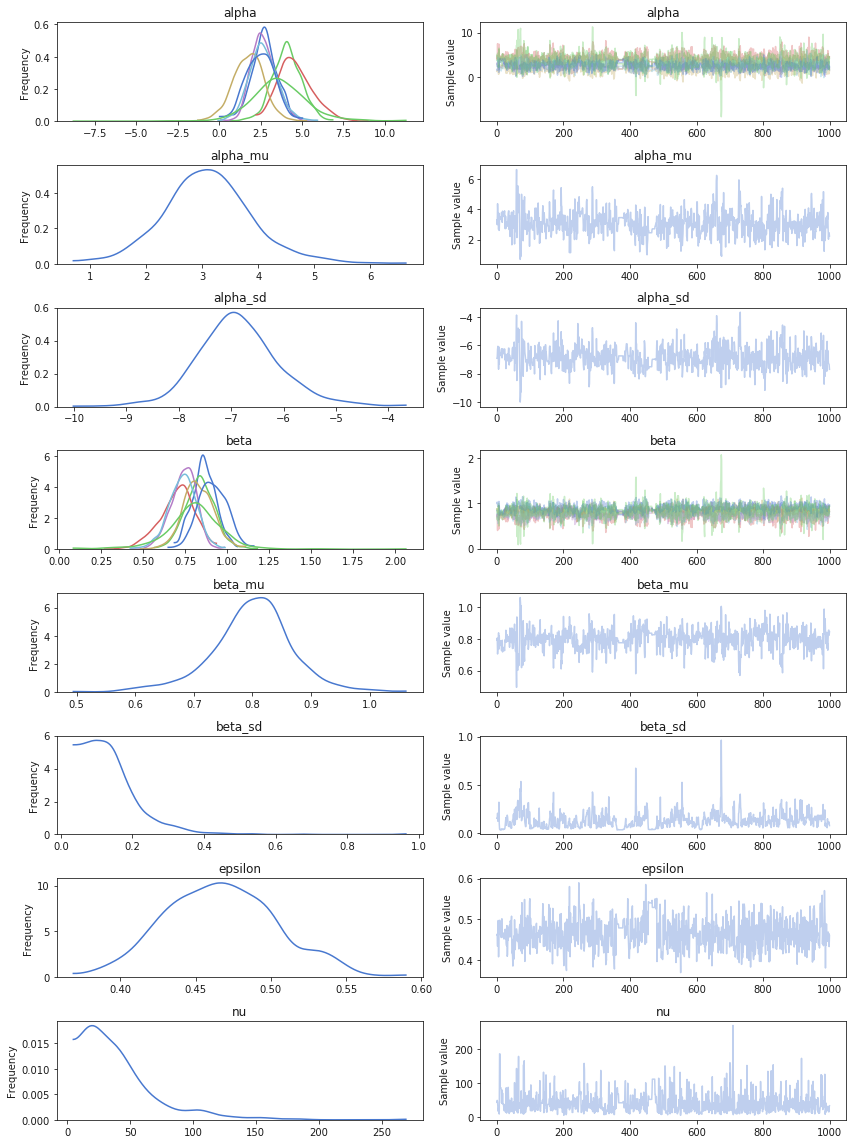

In [53]:
varnames=['alpha', 'alpha_mu', 'alpha_sd', 'beta', 'beta_mu', 'beta_sd', 'epsilon', 'nu']
pm.traceplot(trace_hm, varnames)


In [54]:
pm.df_summary(trace_hm, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha__0,2.76,0.71,3.07e-02,1.42,4.16
alpha__1,4.07,0.88,2.83e-02,2.34,5.77
alpha__2,4.60,1.04,4.60e-02,2.88,6.92
alpha__3,2.69,0.74,2.73e-02,1.35,4.13
alpha__4,1.77,0.93,3.32e-02,-0.20,3.51
alpha__5,2.67,0.86,3.59e-02,1.12,4.52
alpha__6,2.47,0.87,4.40e-02,0.77,4.08
alpha__7,3.64,1.83,7.72e-02,0.37,7.35
alpha_mu,3.11,0.81,3.81e-02,1.56,4.86
alpha_sd,-6.86,0.79,3.41e-02,-8.45,-5.23


## Polynomial regression

Text(0,0.5,'$y$')

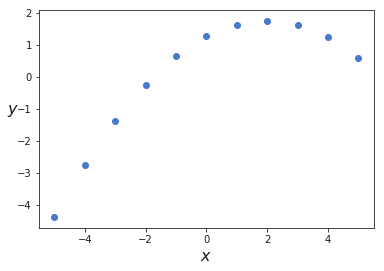

In [57]:
#ans = sns.load_dataset('anscombe')
x_2 = ans[ans.dataset == 'II']['x'].values
y_2 = ans[ans.dataset == 'II']['y'].values
x_2 = x_2 - x_2.mean()
y_2 = y_2 - y_2.mean()

plt.scatter(x_2, y_2)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)


In [58]:
with pm.Model() as model_poly:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta1 = pm.Normal('beta1', mu=0, sd=1)
    beta2 = pm.Normal('beta2', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = alpha + beta1 * x_2 + beta2 * x_2**2
    
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y_2)

    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_poly = pm.sample(2000, step=step, start=start)

logp = 49.209, ||grad|| = 409.18: 100%|██████████| 85/85 [00:00<00:00, 3098.52it/s]           
/home/ohalloranb/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|██████████| 2500/2500 [00:02<00:00, 1090.03it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fde75e68828>,
      dtype=object)

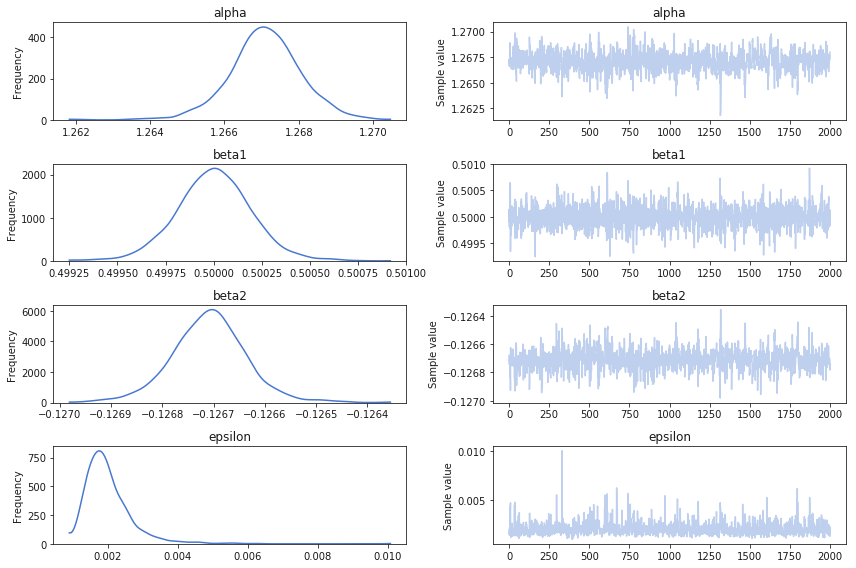

In [59]:
pm.traceplot(trace_poly)


In [60]:
pm.df_summary(trace_poly)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,1.27e+00,9.70e-04,3.60e-05,1.27e+00,1.27e+00
beta1,5.00e-01,2.00e-04,4.79e-06,5.00e-01,5.00e-01
beta2,-1.27e-01,7.23e-05,2.59e-06,-1.27e-01,-1.27e-01
epsilon,2.01e-03,6.78e-04,2.25e-05,1.09e-03,3.30e-03


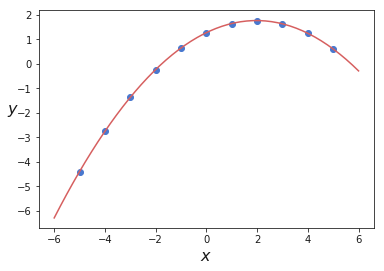

In [61]:
x_p = np.linspace(-6, 6)
y_p = trace_poly['alpha'].mean() + trace_poly['beta1'].mean() * x_p + trace_poly['beta2'].mean() * x_p**2
plt.scatter(x_2, y_2)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.plot(x_p, y_p, c='r')


## Multiple Linear regression

In [62]:
np.random.seed(314)
N = 100
alpha_real = 2.5
beta_real = [0.9, 1.5]
eps_real = np.random.normal(0, 0.5, size=N)

X = np.array([np.random.normal(i, j, N) for i,j in zip([10, 2], [1, 1.5])])
X_mean = X.mean(axis=1, keepdims=True)
X_centered = X - X_mean
y = alpha_real + np.dot(beta_real, X) + eps_real

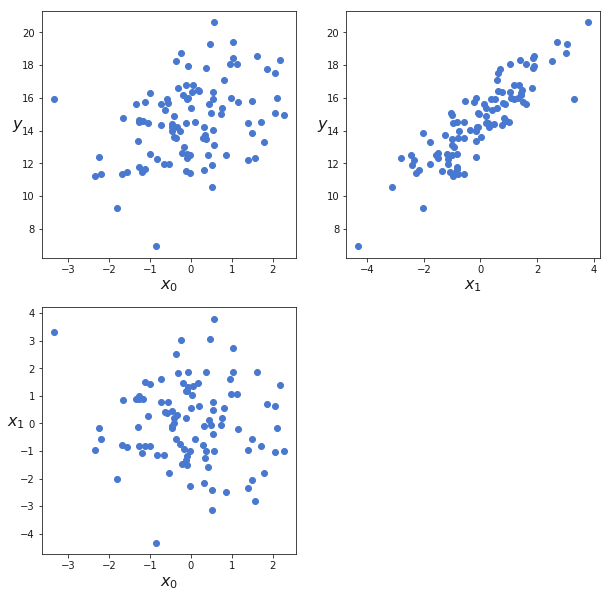

In [63]:
def scatter_plot(x, y):
    plt.figure(figsize=(10, 10))
    for idx, x_i in enumerate(x):
        plt.subplot(2, 2, idx+1)
        plt.scatter(x_i, y)
        plt.xlabel('$x_{}$'.format(idx), fontsize=16)
        plt.ylabel('$y$', rotation=0, fontsize=16)

    plt.subplot(2, 2, idx+2)
    plt.scatter(x[0], x[1])
    plt.xlabel('$x_{}$'.format(idx-1), fontsize=16)
    plt.ylabel('$x_{}$'.format(idx), rotation=0, fontsize=16)

scatter_plot(X_centered, y)


In [64]:
with pm.Model() as model_mlr:
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1, shape=2)
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = alpha_tmp + pm.math.dot(beta, X_centered)

    alpha = pm.Deterministic('alpha', alpha_tmp - pm.math.dot(beta, X_mean)) 

    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)

    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_mlr = pm.sample(5000, step=step, start=start)

logp = -75.778, ||grad|| = 32.757: 100%|██████████| 41/41 [00:00<00:00, 2707.62it/s]   
/home/ohalloranb/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|██████████| 5500/5500 [00:03<00:00, 1493.18it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fde87de11d0>,
      dtype=object)

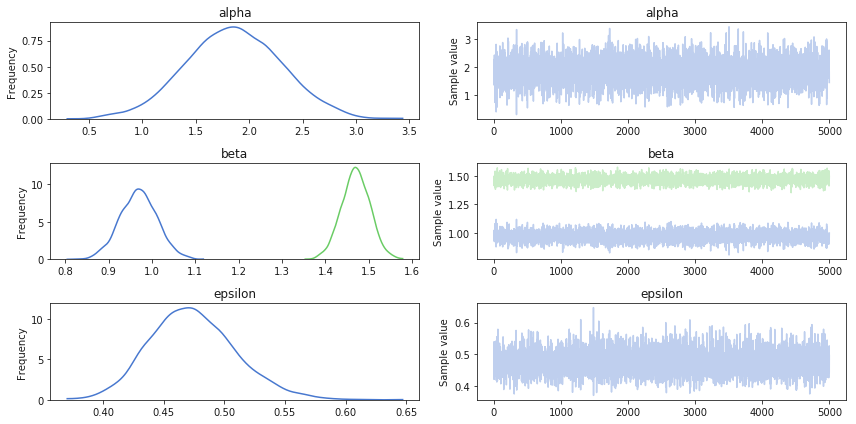

In [65]:
varnames = ['alpha', 'beta','epsilon']
pm.traceplot(trace_mlr, varnames)


In [66]:
pm.df_summary(trace_mlr, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha__0,1.85,0.45,6.12e-03,1.03,2.77
beta__0,0.97,0.04,5.96e-04,0.88,1.05
beta__1,1.47,0.03,3.95e-04,1.40,1.53
epsilon,0.47,0.04,4.29e-04,0.41,0.54


In [67]:
pm.df_summary(trace_mlr, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha__0,1.85,0.45,6.12e-03,1.03,2.77
beta__0,0.97,0.04,5.96e-04,0.88,1.05
beta__1,1.47,0.03,3.95e-04,1.40,1.53
epsilon,0.47,0.04,4.29e-04,0.41,0.54


## Confounding variables and redundant variables

In [68]:
np.random.seed(314)
N = 100
x_1 = np.random.normal(size=N)
x_2 = x_1 + np.random.normal(size=N, scale=1)
#x_2 = x_1 + np.random.normal(size=N, scale=0.01)  
y = x_1 + np.random.normal(size=N)
X = np.vstack((x_1, x_2))

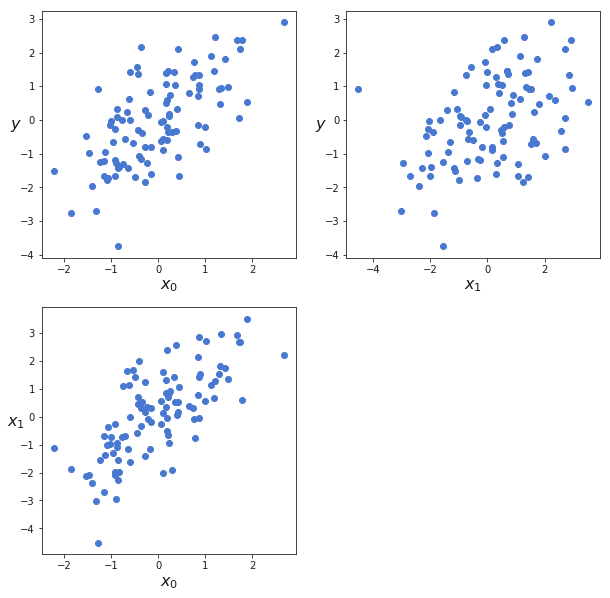

In [69]:
scatter_plot(X, y)


In [70]:
with pm.Model() as model_red:
    alpha = pm.Normal('alpha', mu=0, sd=1)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    #beta = pm.Normal('beta', mu=0, sd=10)
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = alpha + pm.math.dot(beta, X)
    #mu = alpha + beta * X[0]
    
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
 
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_red = pm.sample(5000, step=step, start=start)

logp = -149.13, ||grad|| = 0.08875: 100%|██████████| 15/15 [00:00<00:00, 2420.81it/s]  
/home/ohalloranb/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|██████████| 5500/5500 [00:04<00:00, 1254.42it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fde7f9b4f98>,
      dtype=object)

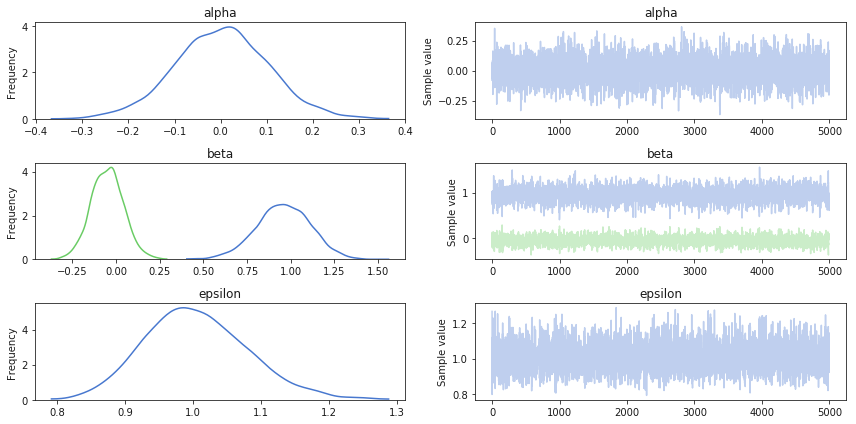

In [71]:
pm.traceplot(trace_red)


In [72]:
pm.df_summary(trace_red)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,9.13e-04,0.10,1.27e-03,-0.20,0.20
beta__0,9.55e-01,0.15,3.34e-03,0.67,1.27
beta__1,-5.12e-02,0.09,1.90e-03,-0.24,0.13
epsilon,1.01e+00,0.08,1.02e-03,0.87,1.16


Text(0,0.5,'$\\beta_2$')

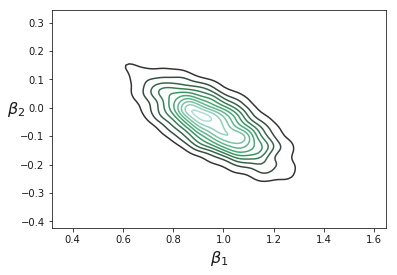

In [73]:
sns.kdeplot(trace_red['beta'][:,0], trace_red['beta'][:,1])
plt.xlabel(r'$\beta_1$', fontsize=16)
plt.ylabel(r'$\beta_2$', fontsize=16, rotation=0)


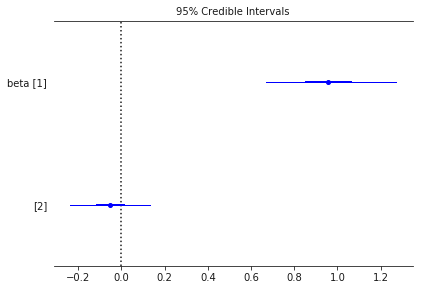

In [74]:
pm.forestplot(trace_red, varnames=['beta'])


## Masking effect variables

In [75]:
np.random.seed(314)
N = 100
r = 0.8
x_0 = np.random.normal(size=N)
x_1 = np.random.normal(loc=x_0 * r, scale=(1 - r ** 2) ** 0.5)
y = np.random.normal(loc=x_0 - x_1)
X = np.vstack((x_0, x_1))

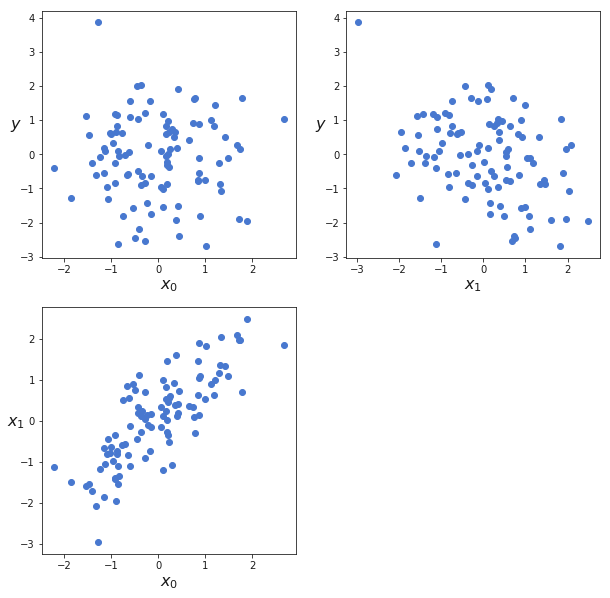

In [76]:
scatter_plot(X, y)


In [77]:
with pm.Model() as model_ma:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    #beta = pm.Normal('beta', mu=0, sd=10)
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = alpha + pm.math.dot(beta, X)
    #mu = alpha + beta * X[0]

    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)

    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_ma = pm.sample(5000, step=step, start=start)

logp = -151.44, ||grad|| = 0.011018: 100%|██████████| 14/14 [00:00<00:00, 2271.84it/s]  
/home/ohalloranb/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|██████████| 5500/5500 [00:05<00:00, 978.36it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fde80b89eb8>,
      dtype=object)

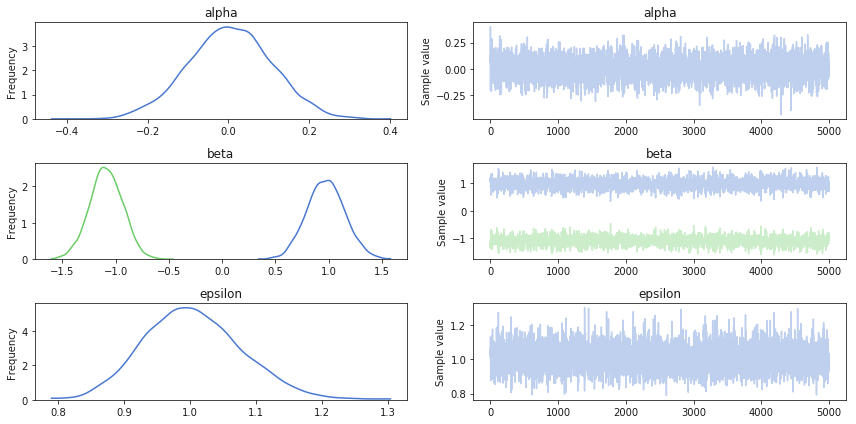

In [78]:
pm.traceplot(trace_ma)


In [79]:
pm.df_summary(trace_ma)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,2.46e-03,0.10,1.46e-03,-0.20,0.21
beta__0,9.75e-01,0.18,3.90e-03,0.64,1.33
beta__1,-1.09e+00,0.16,3.43e-03,-1.39,-0.78
epsilon,1.01e+00,0.07,9.91e-04,0.86,1.14


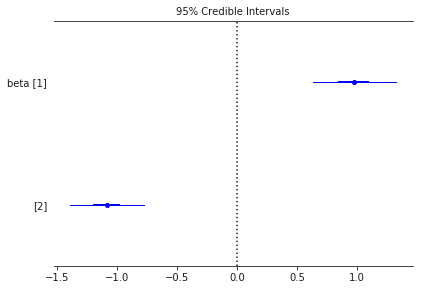

In [80]:
pm.forestplot(trace_ma, varnames=['beta']);


In [81]:
import sys, IPython, scipy, matplotlib, platform

print("This notebook was created on a %s computer running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__, sns.__version__))

This notebook was created on a x86_64 computer running Fedora 28 and using:
Python 3.6.3
IPython 6.1.0
PyMC3 3.2
NumPy 1.14.2
SciPy 1.0.0
Matplotlib 2.1.2
Seaborn 0.8.0

